In [73]:
import pandas as pd
import os 
import numpy as np

import matplotlib.pyplot as plt

plt.rcParams["font.size"] = 8
plt.rcParams["figure.dpi"] = 80
plt.rcParams["lines.linewidth"] = .6

fpath = os.path.join(os.getcwd(),"data")

fpower = os.path.join(fpath, "230420 influx - LabHS - power shellies.csv")
ffactory = os.path.join(fpath, "230420 influx - AFB.csv")

#### power

In [74]:
power = pd.read_csv(fpower,skiprows=3)
power = power.drop(columns=['Unnamed: 0','result'])

for c in ['_start','_stop','_time']: power[c] = pd.to_datetime(power[c])
power.info()

#pd.DataFrame.to_csv(power, os.path.join(fpath, "power.csv"), index=None)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260909 entries, 0 to 260908
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype              
---  ------        --------------   -----              
 0   table         260909 non-null  int64              
 1   _start        260909 non-null  datetime64[ns, UTC]
 2   _stop         260909 non-null  datetime64[ns, UTC]
 3   _time         260909 non-null  datetime64[ns, UTC]
 4   _value        260909 non-null  float64            
 5   Device        260909 non-null  object             
 6   Location      260909 non-null  int64              
 7   Sensor        260909 non-null  object             
 8   _field        260909 non-null  object             
 9   _measurement  260909 non-null  object             
 10  host          260909 non-null  object             
 11  topic         260909 non-null  object             
dtypes: datetime64[ns, UTC](3), float64(1), int64(2), object(6)
memory usage: 23.9+ MB


In [75]:
power_time_min = power['_time'].min()
power_time_max = power['_time'].max()

power_time_range = power_time_max - power_time_min
power_time_range = (power_time_range / 1e9)

power_time_min ,power_time_max ,power_time_range.to_timedelta64()

(Timestamp('2023-04-04 16:09:25.378702087+0000', tz='UTC'),
 Timestamp('2023-04-20 09:57:50.383191985+0000', tz='UTC'),
 numpy.timedelta64(1360105,'ns'))

In [76]:
power['_time_hour'] = power['_time'].dt.hour.to_numpy()

power_per_hour = power.groupby('_time_hour')['_value'].agg(['sum']).reset_index()
print(power_per_hour.to_markdown())

|    |   _time_hour |              sum |
|---:|-------------:|-----------------:|
|  0 |            0 | 803179           |
|  1 |            1 | 832385           |
|  2 |            2 | 824132           |
|  3 |            3 | 820674           |
|  4 |            4 | 847309           |
|  5 |            5 | 825616           |
|  6 |            6 | 824371           |
|  7 |            7 | 817318           |
|  8 |            8 | 852501           |
|  9 |            9 | 847811           |
| 10 |           10 | 819008           |
| 11 |           11 | 847201           |
| 12 |           12 | 951188           |
| 13 |           13 | 899599           |
| 14 |           14 | 866023           |
| 15 |           15 | 860788           |
| 16 |           16 | 840408           |
| 17 |           17 | 850406           |
| 18 |           18 | 853921           |
| 19 |           19 | 842527           |
| 20 |           20 | 833393           |
| 21 |           21 | 833814           |
| 22 |          

In [77]:
power_per_hour_location = power.groupby(['_time_hour','Location'])['_value'].agg(['sum']).reset_index()

print(power_per_hour_location.sort_values(by=['Location','_time_hour']).to_markdown())

|    |   _time_hour |   Location |              sum |
|---:|-------------:|-----------:|-----------------:|
|  0 |            0 |       9306 |  65426.3         |
|  3 |            1 |       9306 |  68697.7         |
|  6 |            2 |       9306 |  68048.4         |
|  9 |            3 |       9306 |  72934.1         |
| 12 |            4 |       9306 |  61431           |
| 15 |            5 |       9306 |  61637.4         |
| 18 |            6 |       9306 |  62849.9         |
| 21 |            7 |       9306 |  71302.5         |
| 24 |            8 |       9306 |  72155           |
| 27 |            9 |       9306 |  64425.2         |
| 30 |           10 |       9306 |  61947           |
| 33 |           11 |       9306 |  59908.4         |
| 36 |           12 |       9306 |  71360           |
| 39 |           13 |       9306 |  64117           |
| 42 |           14 |       9306 |  64187.7         |
| 45 |           15 |       9306 |  61895.6         |
| 48 |           16 |       

In [78]:
print(f"devices: {power['Device'].unique()}")

devices: ['TraverseFlur' 'XRCool' 'XRL08' 'server1' 'server2' 'xair']


In [79]:
consum = power.loc[power['Device'].isin(['server1', 'server2']),['_time','_value','Device']].sort_values(by=['_time'])
consum.reset_index(inplace=True, drop=True)
consum.columns = ['_time','_value','_device']

consum._time = consum._time.dt.floor('MIN')
consum = consum.sort_values(by=['_time'])

print(f"server(1,2) power consumtion: {consum._value.sum():.3f}")

s1 = consum.loc[consum['_device']=='server1',['_time','_value']]
s2 = consum.loc[consum['_device']=='server2',['_time','_value']]

consum = pd.merge(s1, s2, left_on='_time', right_on='_time', how='outer')
consum.columns = ['_time','_value_1','_value_2']
consum['_value'] = consum[['_value_1','_value_2']].sum(axis=1)

consum = consum.groupby(by=['_time']).agg(np.mean).reset_index()
consum

server(1,2) power consumtion: 18352373.510


,_time,_value_1,_value_2,_value
0,2023-04-04 16:09:00+00:00,137.710000,138.18000,275.890000
1,2023-04-04 16:10:00+00:00,137.960000,138.36000,276.320000
2,2023-04-04 16:11:00+00:00,138.450000,138.80500,277.255000
3,2023-04-04 16:12:00+00:00,138.180000,139.64250,277.822500
4,2023-04-04 16:13:00+00:00,134.974286,135.89875,270.873036
...,...,...,...,...
22659,2023-04-20 09:53:00+00:00,162.420000,169.63000,332.050000
22660,2023-04-20 09:54:00+00:00,163.620000,169.45500,333.075000
22661,2023-04-20 09:55:00+00:00,164.930000,169.47500,334.405000
22662,2023-04-20 09:56:00+00:00,163.595000,172.15500,335.750000


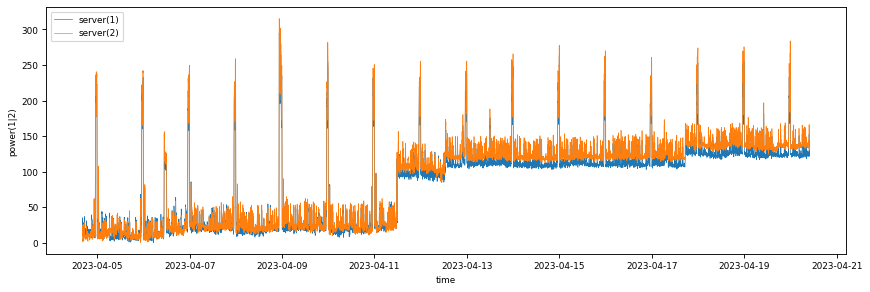

In [80]:
ncols,nrows = 1,1
nwidth,nheight = 16,4

fig, ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=[nwidth*ncols,nheight*nrows],dpi=plt.rcParams["figure.dpi"])
fig.subplots_adjust(right=0.75)

window_size = 10
tt = consum._time.to_numpy()[window_size:]

yy = consum._value 
yy = yy.rolling(window_size, min_periods=1, win_type='parzen').sum()

y1 = consum._value_1
y1 = y1.rolling(window_size, min_periods=1, win_type='parzen').sum()
y1 = y1[window_size:]
y1min = y1.min(); y1 = y1 - y1min

y2 = consum._value_2
y2 = y2.rolling(window_size, min_periods=1, win_type='parzen').sum()
y2 = y2[window_size:]
y2min = y2.min(); y2 = y2 - y2min

ax.plot(tt,y1,"-",label="server(1)")
ax.plot(tt,y2,"-",label="server(2)")
ax.legend()
ax.set_xlabel("time")
ax.set_ylabel("power(1|2)")

plt.show()
plt.close()

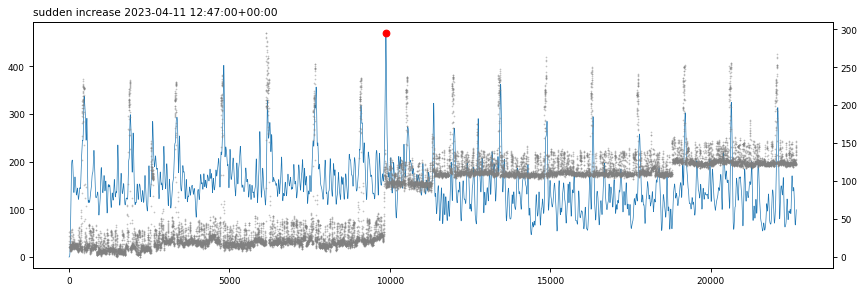

In [81]:
vv = consum._value.to_numpy()
tt = consum._time.to_numpy()

dv = pd.Series(vv[1:]-vv[:-1]).abs()
yy = dv.rolling(100, min_periods=1, win_type='parzen').sum()

xx = np.arange(len(yy))

xm = yy.argmax()
ym = yy[xm]

tm = tt[xm]

# -----------------------------------

ncols,nrows = 1,1
nwidth,nheight = 16,4

fig, ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=[nwidth*ncols,nheight*nrows],dpi=plt.rcParams["figure.dpi"])
fig.subplots_adjust(right=0.75)

ax.plot(xx,yy)
ax.plot([xm],[ym],"o",color="red")

ax.twinx().plot(y1,".",ms=1,color="grey",alpha=0.5)

ax.set_title("sudden increase %s"%(tm),x=0,ha="left")

plt.show()
plt.close()

In [83]:
power_srv = power.loc[power['Device']=='server1',:].reindex()

outlier_value = 175
outlier_correction = 25

# correct outlier
power_srv.loc[power_srv['_value'] > outlier_value,'_value'] = power_srv.loc[power_srv['_value'] > outlier_value,'_value'].to_numpy() - outlier_correction

power_srv.loc[(power_srv['_value'] > outlier_value) 
              & ~(power_srv['_time'].dt.hour.isin([22,23,24,0,1,2,3]))
              ,['_time','_value','Device','Sensor','Location']]


,_time,_value,Device,Sensor,Location
177634,2023-04-13 11:58:46.866152481+00:00,185.44,server1,power,9308


### factory

In [84]:
factory = pd.read_csv(ffactory,skiprows=3)
factory = factory.drop(columns=['Unnamed: 0','result'])

for c in ['_start','_stop','_time']:
    factory[c] = pd.to_datetime(factory[c])

factory.info()

#pd.DataFrame.to_csv(factory, os.path.join(fpath, "factory.csv"), index=None)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31317 entries, 0 to 31316
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   table         31317 non-null  int64              
 1   _start        31317 non-null  datetime64[ns, UTC]
 2   _stop         31317 non-null  datetime64[ns, UTC]
 3   _time         31317 non-null  datetime64[ns, UTC]
 4   _value        31317 non-null  int64              
 5   Assembly      31317 non-null  object             
 6   Signal        31317 non-null  object             
 7   _field        31317 non-null  object             
 8   _measurement  31317 non-null  object             
 9   host          31317 non-null  object             
 10  topic         31317 non-null  object             
dtypes: datetime64[ns, UTC](3), int64(2), object(6)
memory usage: 2.6+ MB


In [85]:
factory_time_range = factory['_time'].max() - factory['_time'].min()
print(f"time range {factory_time_range}")

factory_time_min = factory['_time'].min()
factory_time_max = factory['_time'].max()

factory_time_range = factory_time_max - factory_time_min
factory_time_range = (factory_time_range / 1e9)

factory_time_min ,factory_time_max ,factory_time_range.to_timedelta64()

time range 0 days 03:58:55.391193769


(Timestamp('2023-04-12 07:24:48.807770123+0000', tz='UTC'),
 Timestamp('2023-04-12 11:23:44.198963892+0000', tz='UTC'),
 numpy.timedelta64(14335,'ns'))

In [86]:
factory_assembly_signal = factory[['Assembly','Signal']].groupby('Assembly').agg({'Signal':pd.Series.nunique}).reset_index()
print(factory_assembly_signal.to_markdown())
print(f"signals: {len(factory['Signal'].unique())}")

|    | Assembly     |   Signal |
|---:|:-------------|---------:|
|  0 | Conveyor     |       54 |
|  1 | Distributing |       19 |
|  2 | Filling      |       37 |
|  3 | InOut        |        1 |
|  4 | Packaging    |       20 |
|  5 | Separating   |       14 |
|  6 | Unpacking    |       22 |
signals: 138


In [87]:
lories = factory.loc[(factory['Signal']=='KameraP') & (factory['_value']!=0),'_value'].unique()
print(f"{lories} count {len(lories)}")

[ 5 20 12 10] count 4


In [88]:
cycles = factory.loc[(factory['Signal']=='KameraP') & (factory['_value']!=0),['_time','_value']].sort_values(by=['_value','_time'])

cycles['dt'] = (cycles['_time'] - cycles['_time'].shift(1)).dt.total_seconds()
cycles.loc[(cycles['dt'] > 100) | (cycles['dt'] < 0),'dt'] = np.NaN

cycles = cycles[['_value','dt']].groupby(by=['_value'])['dt'].agg(['mean','std','count']).reset_index()
cycles.columns = ['lorry','_mean','_dev','_count']

cycles

,lorry,_mean,_dev,_count
0,5,61.775561,2.974102,13
1,10,61.823726,3.430666,11
2,12,62.279425,3.227177,11
3,20,61.774972,3.293820,13


In [89]:
frame = factory.loc[(factory['Signal'].isin(['KameraP','10B3'])) & (factory['Assembly'].isin(['Packaging','Conveyor'])),['_time','Signal','Assembly','_value']]
frame = frame[((frame['_value']!=0) & (frame['Signal']=='KameraP') & (frame['Assembly']=='Packaging')) | ((frame['Signal']=='10B3') & (frame['Assembly']=='Conveyor'))]
frame = frame.sort_values(by=['_time']).reset_index().drop(columns=['index'])

index = frame[(frame['Signal']=='KameraP') & (frame['Assembly']=='Packaging')].index

for k in list(zip(index[::1],index[1:-1:1])): 
    _id = frame.iloc[k[0],:]._value
    _value = frame.iloc[k[0]+1:k[1]-1,:]._value.sum()
    _time = frame.iloc[k[0],:]._time
    _batch = 1 if _value < 4 else 0
    print(f"{_id:02d} |-{_value:1d}-| {_time.strftime('%H:%M:%S %d.%m.%Y')} | {_batch}")


05 |-4-| 07:28:48 12.04.2023 | 0
20 |-4-| 07:29:01 12.04.2023 | 0
12 |-4-| 07:29:13 12.04.2023 | 0
10 |-4-| 07:29:39 12.04.2023 | 0
05 |-4-| 07:29:51 12.04.2023 | 0
20 |-4-| 07:30:04 12.04.2023 | 0
12 |-4-| 07:30:16 12.04.2023 | 0
10 |-4-| 07:30:37 12.04.2023 | 0
05 |-4-| 07:30:49 12.04.2023 | 0
20 |-4-| 07:31:09 12.04.2023 | 0
12 |-4-| 07:31:21 12.04.2023 | 0
10 |-4-| 07:31:36 12.04.2023 | 0
05 |-4-| 07:31:48 12.04.2023 | 0
20 |-4-| 07:32:09 12.04.2023 | 0
12 |-4-| 07:32:21 12.04.2023 | 0
10 |-4-| 07:32:35 12.04.2023 | 0
05 |-4-| 07:32:47 12.04.2023 | 0
20 |-4-| 07:33:09 12.04.2023 | 0
12 |-4-| 07:33:21 12.04.2023 | 0
10 |-4-| 07:33:34 12.04.2023 | 0
05 |-4-| 07:33:46 12.04.2023 | 0
20 |-4-| 07:34:15 12.04.2023 | 0
12 |-4-| 07:34:27 12.04.2023 | 0
10 |-4-| 07:34:41 12.04.2023 | 0
05 |-4-| 07:34:52 12.04.2023 | 0
20 |-4-| 07:35:18 12.04.2023 | 0
12 |-4-| 07:35:30 12.04.2023 | 0
10 |-4-| 07:35:45 12.04.2023 | 0
05 |-4-| 07:35:57 12.04.2023 | 0
20 |-4-| 07:36:16 12.04.2023 | 0
12 |-8-| 0

In [90]:
_camera = factory.loc[(factory['Signal']=='KameraP') & (factory['_value']!=0),['_time','Signal','Assembly','_value']]
_10B3 = factory.loc[factory['Signal']=='10B3',['_time','Signal','Assembly','_value']]


['red', 'green', 'blue', 'navy']


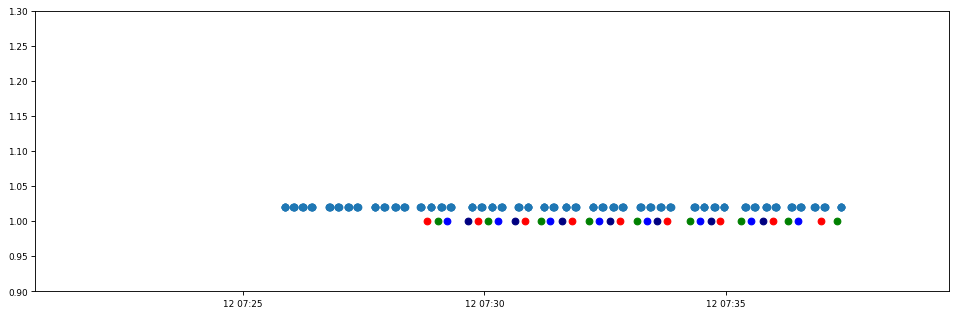

In [131]:
_lorries = _camera["_value"].unique()

import matplotlib as mpl

plt.rcParams["font.size"] = 8
plt.rcParams["figure.dpi"] = 80
plt.rcParams["lines.linewidth"] = .8

ncols,nrows = 1,1
nwidth,nheight = 12,4

fig, ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=[nwidth*ncols,nheight*nrows],dpi=plt.rcParams["figure.dpi"])
fig.subplots_adjust(right=0.75)

cmap = mpl.colormaps['Reds']

colors = ['red','green','blue','navy']

print(colors)

for i,_lorry in enumerate(_lorries):

    xx = _camera.loc[_camera["_value"]==_lorry,"_time"]
    yy = [1] * len(xx)
    ax.plot(xx,yy,"o",color=colors[i])
        
xx = _10B3.loc[_10B3["_value"]!=0,"_time"]      
yy = [1.02] * len(xx)
ax.plot(xx,yy,"o")

dx = ax.get_xlim()[0] + (ax.get_xlim()[1]-ax.get_xlim()[0])/6    
ax.set_xlim([ax.get_xlim()[0], dx])
ax.set_ylim([0.9,1.3])

#ax.set_title("%s"%(_lorry),x=0,ha="left")

plt.tight_layout()
plt.show()
plt.close()